In [12]:
# Let's make this notebook compatible for Python 2 and 3
from __future__ import division, print_function

# Import libraries
import pandas as pd
import numpy as np
import os
import math
import progressbar

# for visualization
import matplotlib.pyplot as plt

# to import module from parent directory
import sys
sys.path.append('..')

# Dataset API from sklearn
from sklearn import datasets

import logging
logging.basicConfig(level=logging.DEBUG)

In [19]:
from utils import normalize, euclidean_distance, batch_iterator
from utils import calculate_covariance_matrix, Plot
from utils.misc import bar_widgets

from deep_learning.activation_functions import Sigmoid

In [20]:
sigmoid = Sigmoid()

class RBM():
    """Bernoulli Restricted Boltzmann Machine (RBM)

    Parameters:
    -----------
    n_hidden: int:
        The number of processing nodes (neurons) in the hidden layer. 
    learning_rate: float
        The step length that will be used when updating the weights.
    batch_size: int
        The size of the mini-batch used to calculate each weight update.
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.

    Reference:
        A Practical Guide to Training Restricted Boltzmann Machines 
        URL: https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf
    """
    def __init__(self, n_hidden=128, learning_rate=0.1, batch_size=10, n_iterations=100):
        self.n_iterations = n_iterations
        self.batch_size = batch_size
        self.lr = learning_rate
        self.n_hidden = n_hidden
        self.progressbar = progressbar.ProgressBar(widgets=bar_widgets)

    def _initialize_weights(self, X):
        n_visible = X.shape[1]
        self.W = np.random.normal(scale=0.1, size=(n_visible, self.n_hidden))
        self.v0 = np.zeros(n_visible)       # Bias visible
        self.h0 = np.zeros(self.n_hidden)   # Bias hidden

    def fit(self, X, y=None):
        '''Contrastive Divergence training procedure'''

        self._initialize_weights(X)

        self.training_errors = []
        self.training_reconstructions = []
        for _ in self.progressbar(range(self.n_iterations)):
            batch_errors = []
            for batch in batch_iterator(X, batch_size=self.batch_size):
                # Positive phase
                positive_hidden = sigmoid(batch.dot(self.W) + self.h0)
                hidden_states = self._sample(positive_hidden)
                positive_associations = batch.T.dot(positive_hidden)

                # Negative phase
                negative_visible = sigmoid(hidden_states.dot(self.W.T) + self.v0)
                negative_visible = self._sample(negative_visible)
                negative_hidden = sigmoid(negative_visible.dot(self.W) + self.h0)
                negative_associations = negative_visible.T.dot(negative_hidden)

                self.W  += self.lr * (positive_associations - negative_associations)
                self.h0 += self.lr * (positive_hidden.sum(axis=0) - negative_hidden.sum(axis=0))
                self.v0 += self.lr * (batch.sum(axis=0) - negative_visible.sum(axis=0))

                batch_errors.append(np.mean((batch - negative_visible) ** 2))

            self.training_errors.append(np.mean(batch_errors))
            # Reconstruct a batch of images from the training set
            idx = np.random.choice(range(X.shape[0]), self.batch_size)
            self.training_reconstructions.append(self.reconstruct(X[idx]))

    def _sample(self, X):
        return X > np.random.random_sample(size=X.shape)

    def reconstruct(self, X):
        positive_hidden = sigmoid(X.dot(self.W) + self.h0)
        hidden_states = self._sample(positive_hidden)
        negative_visible = sigmoid(hidden_states.dot(self.W.T) + self.v0)
        return negative_visible


Training: 100% [-----------------------------------------------] Time:  0:00:07


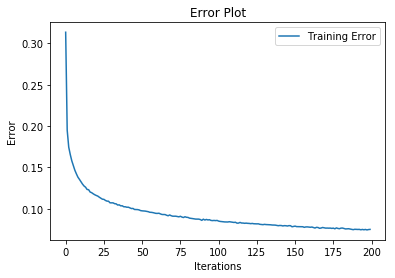

In [21]:
def main():

    mnist = datasets.fetch_mldata('MNIST original')

    X = mnist.data / 255.0
    y = mnist.target

    # Select the samples of the digit 2
    X = X[y == 2]

    # Limit dataset to 500 samples
    idx = np.random.choice(range(X.shape[0]), size=500, replace=False)
    X = X[idx]

    rbm = RBM(n_hidden=50, n_iterations=200, batch_size=25, learning_rate=0.001)
    rbm.fit(X)

    # Training error plot
    training, = plt.plot(range(len(rbm.training_errors)), rbm.training_errors, label="Training Error")
    plt.legend(handles=[training])
    plt.title("Error Plot")
    plt.ylabel('Error')
    plt.xlabel('Iterations')
    plt.show()

    # Get the images that were reconstructed during training
    gen_imgs = rbm.training_reconstructions

    # Plot the reconstructed images during the first iteration
    fig, axs = plt.subplots(5, 5)
    plt.suptitle("Restricted Boltzmann Machine - First Iteration")
    cnt = 0
    for i in range(5):
        for j in range(5):
            axs[i,j].imshow(gen_imgs[0][cnt].reshape((28, 28)), cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("rbm_first.png")
    plt.close()

    # Plot the images during the last iteration
    fig, axs = plt.subplots(5, 5)
    plt.suptitle("Restricted Boltzmann Machine - Last Iteration")
    cnt = 0
    for i in range(5):
        for j in range(5):
            axs[i,j].imshow(gen_imgs[-1][cnt].reshape((28, 28)), cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("rbm_last.png")
    plt.close()


if __name__ == "__main__":
    main()